# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random
import warnings
import seaborn as sns
from skimage import data
from skimage.color import rgb2hed, hed2rgb
import skimage.measure   

from sklearn.metrics import *
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV,cross_validate
from sklearn.linear_model import LinearRegression

! pip install mahotas
import mahotas
from sklearn.decomposition import PCA
import cv2
from sklearn.preprocessing import MinMaxScaler,StandardScaler

from skimage.feature import greycomatrix, greycoprops
from multiprocessing import Pool

from sklearn.model_selection import train_test_split 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random
import warnings
import seaborn as sns
from skimage import data
from skimage.color import rgb2hed, hed2rgb
import skimage.measure   

from skimage import measure
import math
import scipy
import os
import sklearn
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image
import torchvision.transforms as transforms
import shutil
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn as nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision.transforms.transforms import Resize
from PIL import Image

import statsmodels.api as sm
warnings.filterwarnings("ignore")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# update the path in the below snippet

In [5]:
path = '/content/drive/MyDrive/Colab Notebooks/cs429/'

In [6]:
images = np.load(path + 'CoNIC_Challenge/images.npy')
cell_count = pd.read_csv(path+'CoNIC_Challenge/counts.csv')
split = np.loadtxt(path+'split.txt')

# Question - 1

part - (i)

In [7]:
unique_labels, unique_counts = np.unique(split, return_counts=True)
for i in list(zip(unique_labels, unique_counts)):
  print(f'fold-{i[0]}: count-{i[1]}') 

fold-1.0: count-1622
fold-2.0: count-1751
fold-3.0: count-1608


part - (ii)

fold 1.0
T1: Neutrophil count [0 3 0 0 0]
T2: Epithelial count [84 15 65 80 31]
T3: Lymphocyte count [15 11  1  1 61]
T4: Plasma     count [7 2 0 0 6]
T5: Eosinophil count [4 0 0 0 1]
T6: Connective count [19 31  0  7 30]


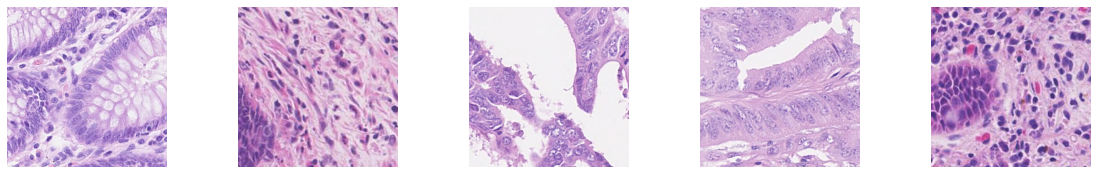

fold 2.0
T1: Neutrophil count [0 0 0 0 2]
T2: Epithelial count [ 79   1  36 100  16]
T3: Lymphocyte count [ 3  7 19  5 12]
T4: Plasma     count [ 0  1 10  0  1]
T5: Eosinophil count [0 1 2 0 0]
T6: Connective count [22 12 44  7 16]


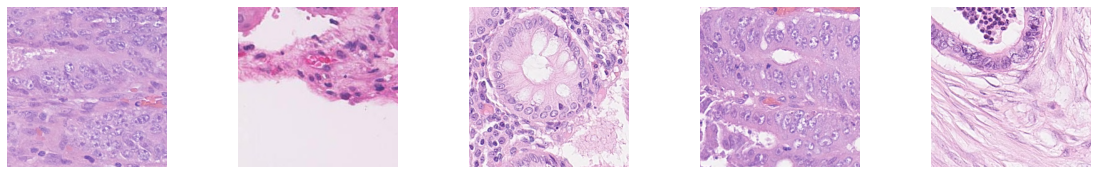

fold 3.0
T1: Neutrophil count [0 0 0 0 0]
T2: Epithelial count [54 56  0 15 63]
T3: Lymphocyte count [ 4  3  1 19  7]
T4: Plasma     count [6 1 0 3 0]
T5: Eosinophil count [0 0 0 0 0]
T6: Connective count [21 15 12 12  0]


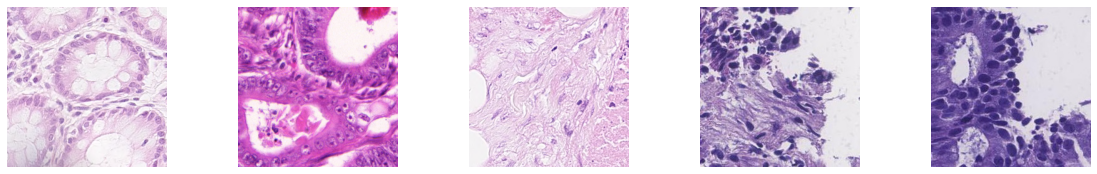

In [10]:
# randomly printing five images in each folds along with each cell type counts
for s in np.unique(split):
  
  print('fold ' + str(s))
  fig = plt.figure(figsize=(20,10))

  y_index = list(np.where(split == s)[0])
  rand_ar = random.sample(y_index,5)
  print('T1: Neutrophil count',cell_count.loc[cell_count.index[rand_ar]].neutrophil.values)
  print('T2: Epithelial count',cell_count.loc[cell_count.index[rand_ar]].epithelial.values)
  print('T3: Lymphocyte count',cell_count.loc[cell_count.index[rand_ar]].lymphocyte.values)
  print('T4: Plasma     count',cell_count.loc[cell_count.index[rand_ar]].plasma.values)
  print('T5: Eosinophil count',cell_count.loc[cell_count.index[rand_ar]].eosinophil.values)
  print('T6: Connective count',cell_count.loc[cell_count.index[rand_ar]].connective.values)
  j = 0
  for i in rand_ar:
    im = images[i]
    plt.subplot(3,5,j+1)
    plt.imshow(im)
    plt.axis('off')
    j += 1
  plt.show()

 Findings
1. The image with the large number of lymphocyte contains more small and dark circular/elliptical black dots 
2. Large number of Epithelial cells is observed when there are more structures seen in the image. Epithelial cells can be related to the number of cells at peripheries of a large circular/elliptical pattern in the image.  

part - (iii)

FOLD =  1


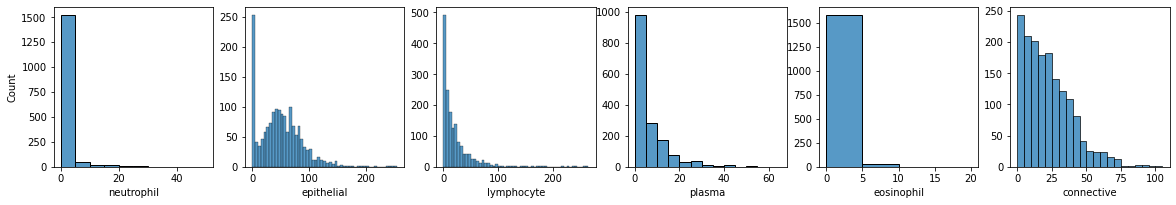

FOLD =  2


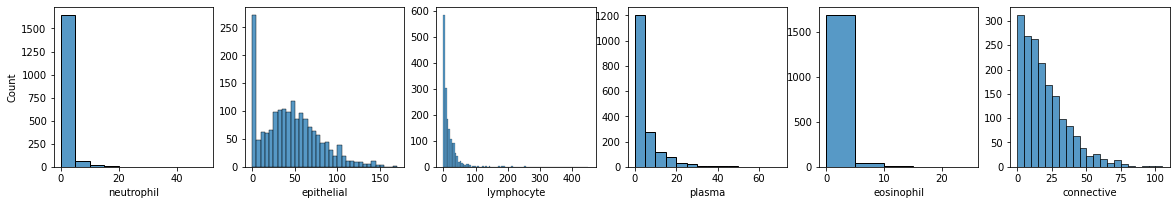

FOLD =  3


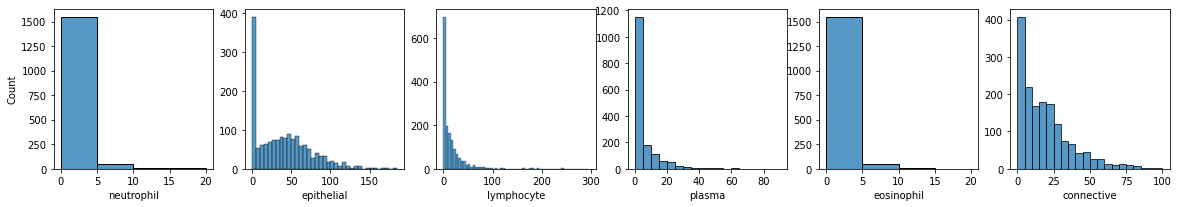

In [11]:
for i in range(1,4):
  k = 0
  fig = plt.figure(figsize=(20,10))
  print('FOLD = ',i)
  for j in cell_count.columns:
    plt.subplot(3,6,k+1)
    df = cell_count.filter(items = list(np.where(split == i)[0]), axis=0)
    # b_w = (max(df[j])-min(df[j]))/50

    sns.histplot(df[j],binwidth=5)
    plt.ylabel('')
    # plt.hist(df[j])
    if k == 0:
      plt.ylabel('Count')
    k += 1

  plt.show()    

In [12]:
def bin_g(col_val):
  if col_val == 0:
    return '0'
  elif col_val >= 1 and col_val <=5:
    return '1-5'
  elif col_val >= 6 and col_val <=10:
    return '6-10'
  elif col_val >= 11 and col_val <=20:
    return '11-20'
  elif col_val >= 21 and col_val <=20:
    return '21-20'
  elif col_val >= 31 and col_val <=40:
    return '31-40'
  elif col_val >= 41 and col_val <=50:
    return '41-50'
  else: return '>50'
df_bin = cell_count.copy()
for col in df_bin.columns:
  df_bin['bin_' + col] = cell_count[col].apply(lambda x: bin_g(x))

In [13]:
for fold in range(1,4):
  df_bin = df_bin
  for id,col in enumerate([i for i in df_bin.columns if i.find('bin')>=0 ]):
    
    if id == 0:
      bin = df_bin.groupby(col).count()
      agg_bin = bin.iloc[:,id].to_frame().reset_index()
      agg_bin.rename(columns = {col : col.split('_')[0]}, inplace = True)
      
    else:
      bin = (df_bin.groupby(col).count())
      agg_bin_e = bin.iloc[:,id].to_frame().reset_index()
      agg_bin_e.rename(columns = {col : col.split('_')[0]}, inplace = True)
      agg_bin = pd.merge(agg_bin,agg_bin_e,on='bin',how='left')

agg_bin

,bin,neutrophil,epithelial,lymphocyte,plasma,eosinophil,connective
0,0,3912,792,625,1878,3731.0,454
1,1-5,867,154,1365,1639,1142.0,636
2,11-20,64,336,888,549,16.0,1211
3,31-40,3,546,312,51,NaN,534
4,41-50,4,569,184,25,NaN,284
5,6-10,121,145,652,656,91.0,686
6,>50,10,2439,955,183,1.0,1176


part - (iv)

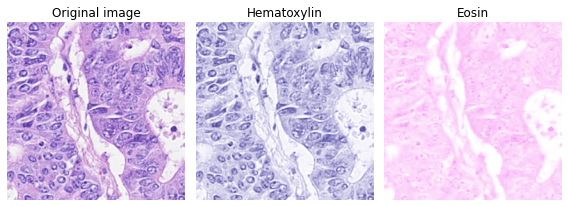

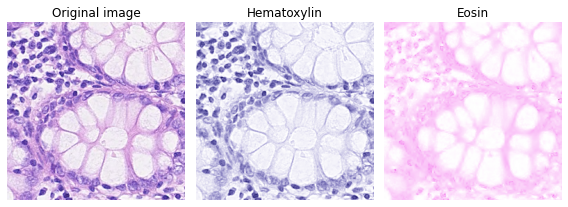

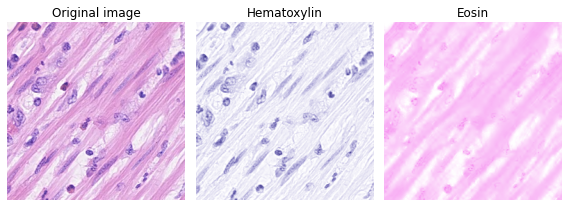

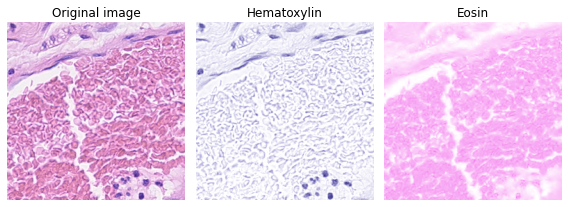

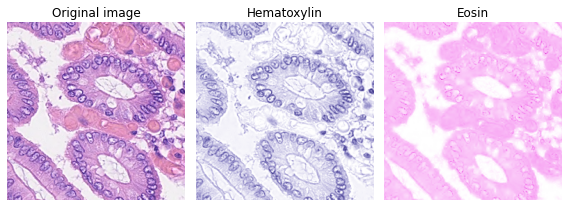

In [14]:
def H_channel(im):
  im_hed = rgb2hed(im)

  # Create an RGB image for each of the stains
  null = np.zeros_like(im_hed[:, :, 0])
  im_h = hed2rgb(np.stack((im_hed[:, :, 0], null, null), axis=-1))
  im_e = hed2rgb(np.stack((null, im_hed[:, :, 1], null), axis=-1))
  im_d = hed2rgb(np.stack((null, null, im_hed[:, :, 2]), axis=-1))

  return im_h,im_e
for i in [0,10,25,30,45]:

  im_h,im_e = H_channel(images[i])
  fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True)
  ax = axes.ravel()

  ax[0].imshow(images[i])
  ax[0].set_title("Original image")

  ax[1].imshow(im_h)
  ax[1].set_title("Hematoxylin")

  ax[2].imshow(im_e)
  ax[2].set_title("Eosin")  # Note that there is no Eosin stain in this image

  for a in ax.ravel():
      a.axis('off')

  fig.tight_layout()

part - (v) 

In [ ]:
h_avg = [] # avg H-channel

# Count
neu_cnt = []	
epi_cnt = []
lym_cnt	= []
pla_cnt = []
eos_cnt	= []
con_cnt = []
fold = 1
im_index = list(np.where(split == fold)[0])
for i in im_index:

  im_h = rgb2hed(images[i])[:,:,0]
  h_avg.append(np.mean(im_h.ravel()))

  neu_cnt.append(cell_count.loc[i].neutrophil)	
  epi_cnt.append(cell_count.loc[i].epithelial)
  lym_cnt.append(cell_count.loc[i].lymphocyte)
  pla_cnt.append(cell_count.loc[i].plasma)
  eos_cnt.append(cell_count.loc[i].eosinophil)
  con_cnt.append(cell_count.loc[i].connective)


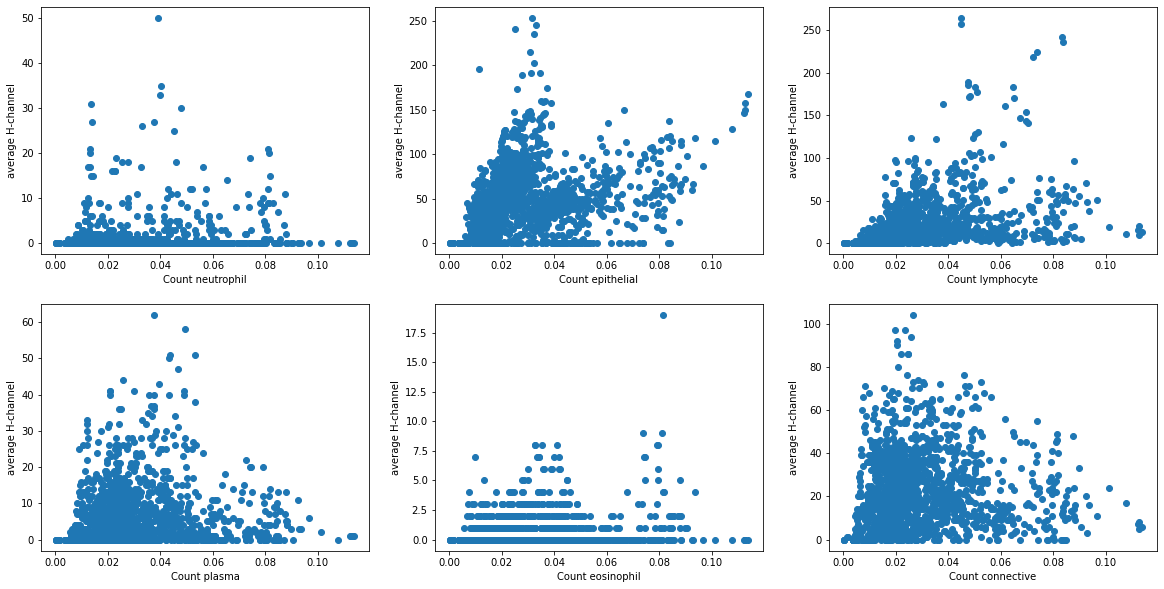

In [ ]:
plt.figure(figsize=(20,10)) # Scatter Plot
for id,i in enumerate([neu_cnt,epi_cnt,lym_cnt,pla_cnt,eos_cnt,con_cnt]):
  plt.subplot(2, 3, id+1)
  plt.scatter(h_avg,i)
  plt.xlabel('Count ' + cell_count.columns[id])
  plt.ylabel('average H-channel')
plt.show()
fig.tight_layout()

In [ ]:
pearsonr(h_avg,lym_cnt)[0]

0.37758024100725857

Reason - It will be an useful feature in regression as it shows positive correlatation with the count of the lymphocyte cells **~.38**  

part - (vi)

For this problem, RMSE, R2, Adjusted R2,  correlation cofficients such as pearson/spearman can be used for the evaluation of the model. R2 is bounded and interpretable in terms of explained variance of the target variable. But R2 also has some downside as well, such as it does not represents the goodness of fit, and often results in high value while overfitting of the model also in case of correlated features it may result in  inflated R2. In that scenario adjusted R2 works better. Correlation metrices can show high correlation value if the model consistently under-predicted or over-predicted the target variable but the predictions are linearly related with actual values. Problem with RMSE is, its not easy to interpret because we know low rmse represents good models, but how low eventually it should be? Also, it punishes harshly to the outliers and the training could get biased to farther points. So overall, I will have a look at all the metrices performance together to have a complete idea.

# Question - 2
part - (i) --> a,b,c

In [ ]:
# Feature Extraction
# Avereage of H, R,G,B channels
h_avg = []
r_avg = []
g_avg = []
b_avg = []
# Variance of H, R,G,B channels
h_var = []
r_var = []
g_var = []
b_var = []

# Entropy of H, R,G,B channels
h_ent = []
r_ent = []
g_ent = []
b_ent = []
# Cel count
neu_cnt = []	
epi_cnt = []
lym_cnt	= []
pla_cnt = []
eos_cnt	= []
con_cnt = []

for i in range(len(images)):

  im_h = rgb2hed(images[i])[:,:,0]
  h_avg.append(np.mean(im_h.ravel()))
  r_avg.append(np.mean(images[i][:,:,0].ravel()))
  g_avg.append(np.mean(images[i][:,:,1].ravel()))
  b_avg.append(np.mean(images[i][:,:,2].ravel()))

  h_var.append(np.var(im_h.ravel()))
  r_var.append(np.var(images[i][:,:,0].ravel()))
  g_var.append(np.var(images[i][:,:,1].ravel()))
  b_var.append(np.var(images[i][:,:,2].ravel()))

  h_ent.append(skimage.measure.shannon_entropy(im_h))
  r_ent.append(skimage.measure.shannon_entropy(images[i][:,:,0]))
  g_ent.append(skimage.measure.shannon_entropy(images[i][:,:,1]))
  b_ent.append(skimage.measure.shannon_entropy(images[i][:,:,2]))

  neu_cnt.append(cell_count.loc[i].neutrophil)	
  epi_cnt.append(cell_count.loc[i].epithelial)
  lym_cnt.append(cell_count.loc[i].lymphocyte)
  pla_cnt.append(cell_count.loc[i].plasma)
  eos_cnt.append(cell_count.loc[i].eosinophil)
  con_cnt.append(cell_count.loc[i].connective)

part - (i) --> d


Additional features such as (GLCM,Moments,haralic texture) are used of an image to add rich attributes to the modelling.


GLCM --  The GLCM features characterize the texture of an image by estimating how often a pixel appears a neighbour with specific values and in a specified spatial relationship, in an image.
It estimates features such as 
▶ contrast - a measure of the intensity contrast between a pixel and its neighbor over the whole image.
▶ correlation - Returns a measure of how correlated a pixel is to its neighbor over the whole image.
▶ energy - it is also known as uniformity and returns the sum of squared elements in the GLCM.
▶ homogenity - gives value that measures the closeness of the distribution of elements in the GLCM.

Momonets -- moment features are used to describe several properties of an image, such as the intensity of an image, its centroid, the area, and information about its orientation

Haralic Features -- Haralick texture features are used as they are based on GLCM and are common texture descriptors in image analysis. To compute the Haralick features, the image gray-levels are reduced with a process called quantization.

In [ ]:
# FUnction to calculate additional features
def hu_moments(image): # moments
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

def glcm_feature(patch): # GLCM features
    lf = []
    props = ['dissimilarity', 'contrast', 'homogeneity', 'energy', 'correlation','ASM']

    # left nearest neighbor
    glcm = greycomatrix(patch, [1], [0], 256, symmetric=True, normed=True)
    for f in props:
        lf.append( greycoprops(glcm, f)[0,0] )


    glcm = greycomatrix(patch, [1], [np.pi/4], 256, symmetric=True, normed=True)
    for f in props:
        lf.append( greycoprops(glcm, f)[0,0] )

    # upper nearest neighbor
    glcm = greycomatrix(patch, [1], [np.pi/2], 256, symmetric=True, normed=True)
    for f in props:
        lf.append( greycoprops(glcm, f)[0,0] )
        
    return lf

def Haralick_text(image): # Haralic texture feature
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick


In [ ]:
global_features = [] # additional feature extractions
for i in images:

  fv_hu_moments = hu_moments(i)
  fv_haralick   = Haralick_text(i)
  glcm = glcm_feature(cv2.cvtColor(images[0], cv2.COLOR_BGR2GRAY))
  global_feature = np.hstack([fv_haralick, fv_hu_moments,glcm])
  global_features.append(global_feature)

Scatter plot of lymphocyte for each fold with all features from part - i -> (a-c)

In [ ]:
cell_cnt = [neu_cnt,epi_cnt,lym_cnt,pla_cnt,eos_cnt,con_cnt]
avg_chnl = ['H-Averege','R-Average','G-Average','B-Average']
var_chnl = ['H-Variance','R-Variance','G-Variance','B-Variance']
ent_chnl = ['H-Entropy','R-Entropy','G-Entropy','B-Entropy']
features = [h_avg,r_avg,g_avg,b_avg,h_var,r_var,g_var,b_var,h_ent,r_ent,g_ent,b_ent]

def prnt_feat_scatter(fold):
  print(f"########### FOLD -> {fold} ############")
  plt.figure(figsize=(20,10))
  for id, i in enumerate(features):
    # k=1
    plt.subplot(3,4,id+1)

    if id//4 == 0:
      y = np.array(cell_cnt[2])
      x = np.array(i)
      plt.scatter(x[split == fold],y[split == fold])
      plt.title(avg_chnl[id%4])
      
    elif id//4 == 1:
      y = np.array(cell_cnt[2])
      x = np.array(i)
      plt.scatter(x[split == fold],y[split == fold],color = 'r')  
      plt.title(var_chnl[id%4]) 
    else :
      y = np.array(cell_cnt[2])
      x = np.array(i)
      plt.scatter(x[split == fold],y[split == fold],c = 'g')
      plt.title(ent_chnl[id%4])
  plt.show() 
  

########### FOLD -> 1 ############


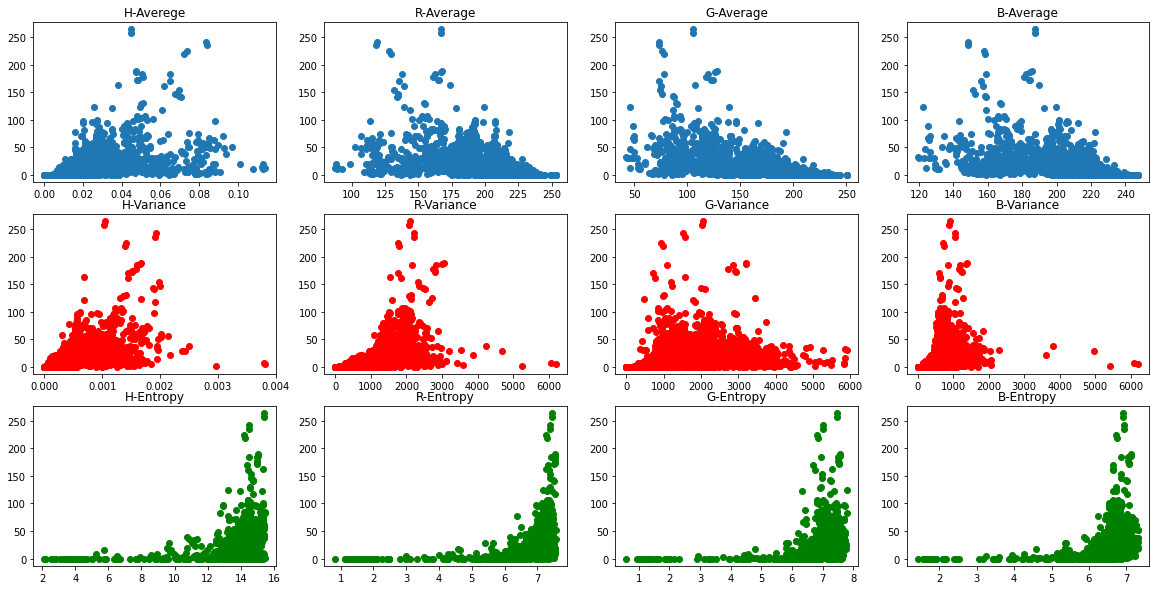

In [ ]:
prnt_feat_scatter(1)

########### FOLD -> 2 ############


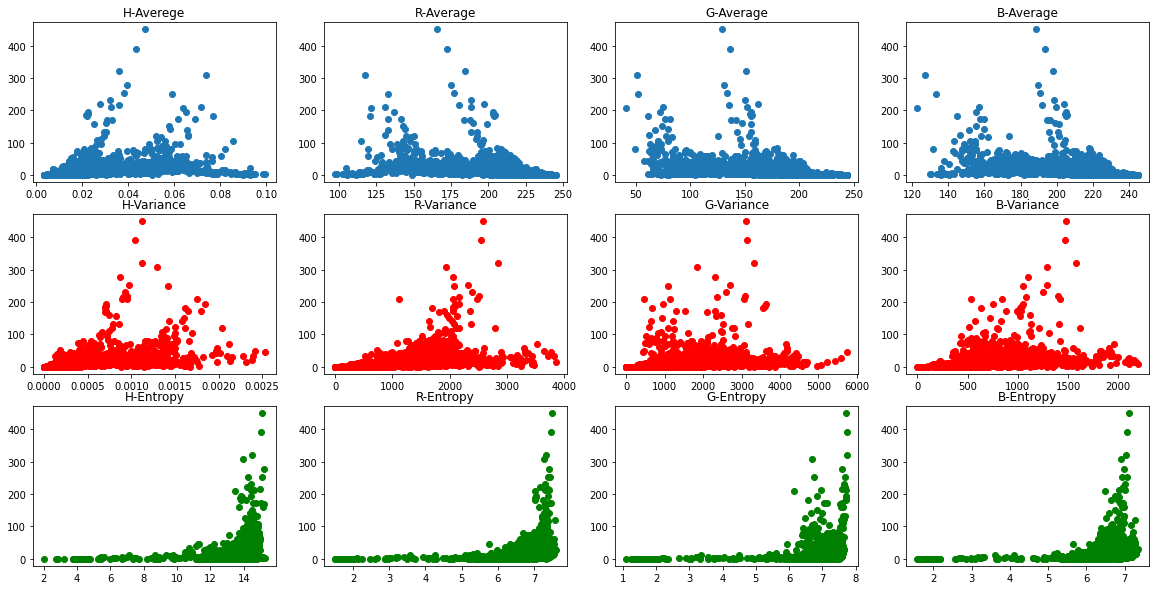

In [ ]:
prnt_feat_scatter(2)

########### FOLD -> 3 ############


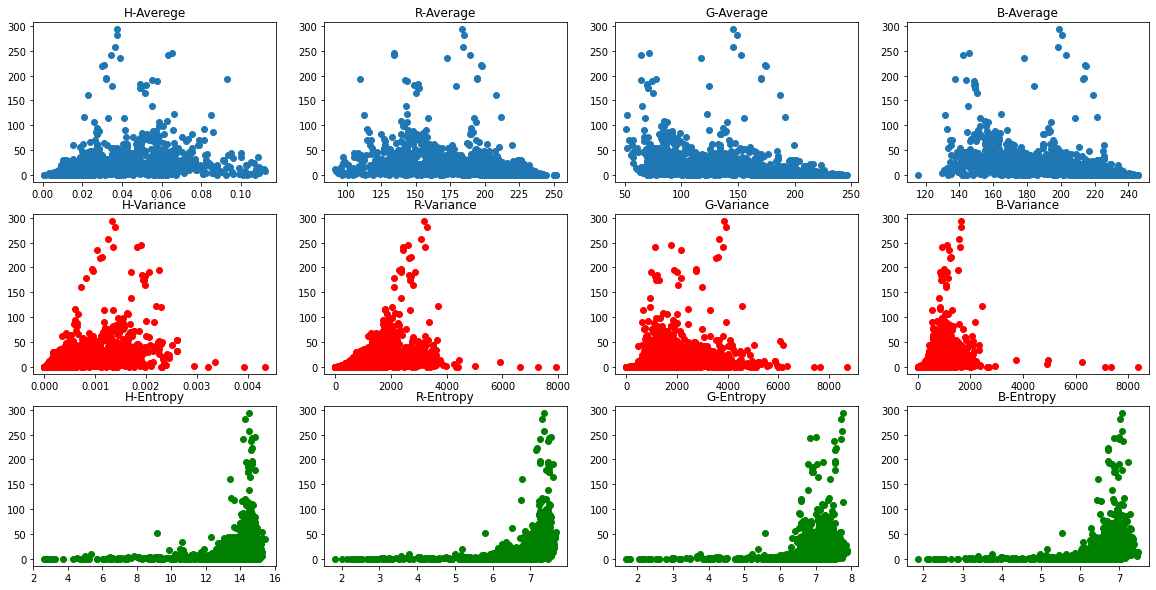

In [ ]:
prnt_feat_scatter(3)

In [ ]:
print('feature( from part -(i) a-c) correlation with lymphocyte(T3) cell count\n')
cor = {}
feat_name = avg_chnl+var_chnl+ent_chnl
for id, i in enumerate(features):
  cor[feat_name[id]] = pearsonr(i,cell_cnt[2])[0]
cor

feature( from part -(i) a-c) correlation with lymphocyte(T3) cell count



{'H-Averege': 0.3310158123883034,
 'R-Average': -0.36046827562410544,
 'G-Average': -0.3856703183773159,
 'B-Average': -0.3757459903735769,
 'H-Variance': 0.43893004675313985,
 'R-Variance': 0.40163870998506573,
 'G-Variance': 0.12884761376222906,
 'B-Variance': 0.24206174107786,
 'H-Entropy': 0.23102974128779008,
 'R-Entropy': 0.32036612575055173,
 'G-Entropy': 0.21574618278377616,
 'B-Entropy': 0.28792081646178264}

Below are the important feature on the basis of minimum 30% correlation cofficient

In [ ]:
{i:j for i,j in cor.items() if abs(j) >= 0.3}

{'H-Averege': 0.3310158123883034,
 'R-Average': -0.36046827562410544,
 'G-Average': -0.3856703183773159,
 'B-Average': -0.3757459903735769,
 'H-Variance': 0.43893004675313985,
 'R-Variance': 0.40163870998506573,
 'R-Entropy': 0.32036612575055173}

part - (ii)

In [ ]:
# function to evaluate models performace on test data.
def evaluate(model,x, y, print1 = 1):

  plt.figure(figsize=(8,8))
  y_pred = model.predict(x)
  y_actl = np.array(y.iloc[:,[2]]).ravel()
  rmse = np.sqrt(mean_squared_error(y_actl,y_pred))
  pearson_corr = pearsonr(y_actl,y_pred)[0]
  spearman_corr = spearmanr(y_actl,y_pred)[0]
  r2 = r2_score(y_actl,y_pred)
  metric = {'rmse':rmse,"pearson_corr":pearson_corr,"spearman_corr":spearman_corr,"r2":r2} # returns all metrics
  
  if print1 ==1 : # prints scatter plot
    plt.scatter(y_actl,y_pred)  
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Lymphocyte (Scatter Plot of test-(Fold:3) data)')

  print(metric)

# Feature Engineering
As the distribution of the count of lymphocyte cells appears to follow a poissons distribution, So converted it to an estimated gaussian distribution using log() function. And it resulted in significant rise in performace of the models.

OLS results:
> without feature engg - {'rmse': 25.145024958450282, 'pearson_corr': 0.6110545473186354, 'spearman_corr': 0.5728804136226114, 'r2': 0.27584194112384497}

> with feature engg - {'rmse': 1.0235839540868095, 'pearson_corr': 0.7129973875298132, 'spearman_corr': 0.7075608636964192, 'r2': 0.4382960005019344}






In [ ]:
for col in cell_count.columns :
  cell_count[col] = cell_count[col].apply(lambda x : np.log(x+1) ) # gaussian approximation

In [ ]:
X = np.hstack((np.array(features).T, np.array(global_features)))
# train and validation dataset preparation
train_indx = list(np.where(split == 1)[0]) + list(np.where(split == 2)[0])
x_train_val = X[train_indx,...] #np.hstack((, x_train_pca))
y_train_val = cell_count.filter(items = train_indx, axis=0)

In [ ]:
mm_scaler = StandardScaler() # scaling the datasets
x_train_val = mm_scaler.fit_transform(x_train_val)

In [ ]:
test_indx = list(np.where(split == 3)[0]) # test datset preparation
x_test = X[test_indx,...] #np.hstack((,pca.transform(np.array([rgb2hed(i)[:,:,0].flatten() for i in images[split==3]]))))
x_test = mm_scaler.transform(x_test)
y_test = cell_count.filter(items = test_indx, axis=0)

OLS model

In [ ]:
l_model = sm.OLS(np.array(y_train_val.iloc[:,[2]]).ravel(),x_train_val)
linear_model = l_model.fit()
 
# printing the summary table
# print(linear_model.summary())

{'rmse': 1.0240571409925514, 'pearson_corr': 0.7128971859874197, 'spearman_corr': 0.704928504437157, 'r2': 0.43777654645633957}


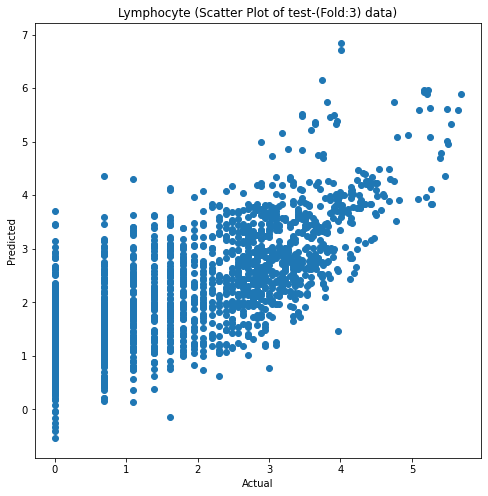

In [ ]:
evaluate(linear_model,x_test,y_test,1)

SVR model

In [ ]:
############### Uncomment to run the Grid-Search#############################

from sklearn.svm import SVR

grid_params_svm = {'C': [0.001,0.01,0.1,0.95,1,1.04,1.05,1.06,10], # Grid parameters for Kernel SVM
                    'kernel': [ 'sigmoid', 'linear', 'rbf','poly'],
                    'degree':[3,6,9]} 


svr_model = GridSearchCV(estimator=SVR(max_iter = 500),
                      param_grid=grid_params_svm,
                      scoring=['neg_root_mean_squared_error','r2'],
                      cv=5,
                      n_jobs=-1,refit='neg_root_mean_squared_error')
svr_model.fit(x_train_val, np.array(y_train_val.iloc[:,[2]]).ravel())
svr_model
print(svr_model.best_score_,svr_model.best_params_)

{'rmse': 0.9555882960446064, 'pearson_corr': 0.7203862035557876, 'spearman_corr': 0.7010741502167137, 'r2': 0.5104441758400303}


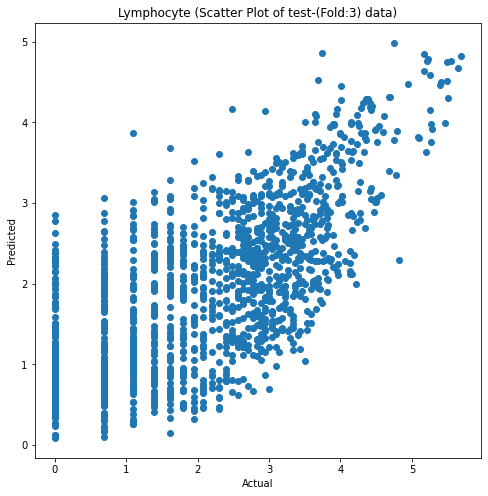

In [ ]:
evaluate(svr_model,x_test,y_test)

# Question - 3 

In [ ]:
# GPU intiallisation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# A class to transform/augment the cards and bring datasets in dataloader format
class CellDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.FloatTensor(targets)
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)




In [ ]:
# function to read the data
def read_data():
    cell_count = pd.read_csv(path +'CoNIC_Challenge/counts.csv')
    images = np.load(path + 'CoNIC_Challenge/images.npy')
    split = np.loadtxt(path +'split.txt')
    
    for col in cell_count.columns :
        cell_count[col] = cell_count[col].apply(lambda x : np.log(x+1)) # gaussian approximation 

    return cell_count,images,split

#Function to prepare the data in the dataloader format, returns dataloader for test, train and validation dataset
def split_level_data(cell_count,images,split,idx_ls,cell_col_idx,batch_size):
    train_indx = list(np.where(split == idx_ls[0])[0]) + list(np.where(split == idx_ls[1])[0]) # dynamic fold consideration
    labels_df = cell_count.filter(items = train_indx, axis=0)
    x_train, x_val, y_train, y_val = train_test_split(images[train_indx,...], labels_df, test_size=0.25, random_state=42) # train-val split

    x_test = images[split==idx_ls[2]]
    y_test = cell_count.filter(items = list(np.where(split == idx_ls[2])[0]), axis=0)
    # list of array of train and test and validatation dataset
    cnn_train_x = [x_train[i] for i in range(x_train.shape[0])]
    cnn_valid_x = [x_val[i] for i in range(x_val.shape[0])]
    cnn_train_y = [np.array([y_train.iloc[i,cell_col_idx]]) for i in range(y_train.shape[0])]
    cnn_val_y = [np.array([y_val.iloc[i,cell_col_idx]]) for i in range(y_val.shape[0])]

    cnn_test_x = [x_test[i] for i in range(x_test.shape[0])]
    cnn_test_y = [np.array([y_test.iloc[i,2]]) for i in range(y_test.shape[0])]

    transform = transforms.Compose([transforms.ToPILImage(), # Input data transformations
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) # normalization
    # Dataloader intialisation for train-val-test
    train_dataset = CellDataset(cnn_train_x, cnn_train_y, transform=transform)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

    valid_dataset = CellDataset(cnn_valid_x, cnn_val_y, transform=transform)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)

    test_dataset = CellDataset(cnn_test_x, cnn_test_y, transform=transform)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    return train_dataloader,valid_dataloader,test_dataloader,y_train,y_val,y_test

In [ ]:
#Function for model training which returns the best model along with train-val loss array
def train_model(loss_fn,model,train_dataloader,valid_dataloader,num_epochs,train_data_len,val_data_len,pprint=True):
    min_loss = 99
    best_model = model
    loss_ls_train = []
    loss_ls_valid = []
    for epoch in range(num_epochs):
        loss_train = 0 
        model.train()
        for data in train_dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            opt.zero_grad()

            outputs = model(inputs) 
            loss = loss_fn(outputs, labels)
            loss.backward()
            opt.step()
            loss_train+=loss.item() 

            del inputs, labels, outputs # del inputs, clear cache to get rid unnecessary logs
            torch.cuda.empty_cache()
      
        loss_valid = 0
        for data in valid_dataloader: # calculates validation loss
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            model.eval()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss_valid+= loss.item()

        if loss_valid < min_loss: # loss comparison to select the best model
            best_model = model
            min_loss = loss_valid

        loss_ls_train.append(loss_train/train_data_len)
        loss_ls_valid.append(loss_valid/val_data_len)

        if pprint: # prints progress with training epochs
            print(f"epoch:{epoch}    train_loss:{round(loss_ls_train[-1],4)}    valid_loss:{round(loss_ls_valid[-1],4)}") 
            
    return best_model,loss_ls_train,loss_ls_valid

In [ ]:
def evaluation(y_pred,y_actl): # returns metrices dictionary for given actual and predicted array
    y_actl =list(y_actl)
    y_pred = list(pd.DataFrame(y_pred).iloc[:,0])
    rmse = np.sqrt(mean_squared_error(y_actl,y_pred))
    pearson_corr = pearsonr(y_actl,y_pred)[0]
    spearman_corr = spearmanr(y_actl,y_pred)[0]
    r2 = r2_score(y_actl,y_pred)
    metric = {'rmse':rmse,"pearson_corr":pearson_corr,"spearman_corr":spearman_corr,"r2":r2} # metrics dictionary
    return metric

# test model's performance on dataloaders and prediction array with evaluation metrics dictionary
def evaluation_metric(data_loader,model,y,num_cells = 1):
    pred = []

    for data in data_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        model.eval()
        outputs = model(inputs)
        pred.append(outputs.detach().cpu().numpy())

    pred = np.vstack(pred)

    return pred,evaluation(pred,y)

In [ ]:
def visualization(loss_ls_train,loss_ls_valid,y_actl,y_pred,fold):
    plt.figure(figsize=(9,4))
## model dev plot
    plt.subplot(1,2,1)
    plt.plot(loss_ls_train)
    plt.plot(loss_ls_valid)
    plt.legend(['train','valid'])
    plt.title("Model convergence plot")

    
## test data scatter plot
    plt.subplot(1,2,2)
    plt.scatter(y_actl,y_pred)
    plt.title(f"Test Data Results fold :{fold}")
    plt.xlabel("Actual count")
    plt.ylabel("Predicted count")
    plt.show()



part - (a)




> Transfer Learning is employed in all the parts of Q-3. It is more efficient when dealing with image dataset, also, in few training epochs it gives better results.


> Restnet18 is trained for all the parts of questions-3 as it is already trained on large corpus of image data and it is least complex model with most effective performance.



> The Progress loss print with epochs is put to false, Change it to True in the below snippet where train_model function is getting called to see the progress.
Or, wait for 4-5 minutes till the result appears.



Train-Valid --> Fold: 1&2 :::: Test--> Fold: 3
epoch:0    train_loss:0.0347    valid_loss:0.0224
epoch:1    train_loss:0.01    valid_loss:0.0125
epoch:2    train_loss:0.0074    valid_loss:0.0072
epoch:3    train_loss:0.0061    valid_loss:0.0081
epoch:4    train_loss:0.0052    valid_loss:0.0189
epoch:5    train_loss:0.0045    valid_loss:0.0177
epoch:6    train_loss:0.004    valid_loss:0.0095
epoch:7    train_loss:0.0041    valid_loss:0.0136
epoch:8    train_loss:0.004    valid_loss:0.0069
epoch:9    train_loss:0.004    valid_loss:0.0097


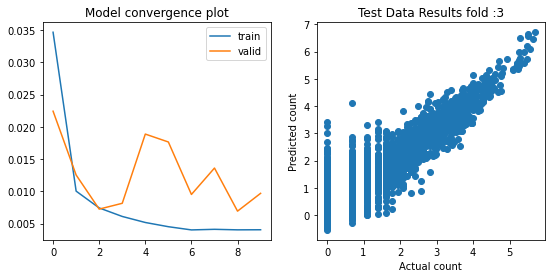

                  train     valid      test
rmse           0.384377  0.545122  0.649494
pearson_corr   0.969768  0.927906  0.908818
spearman_corr  0.971581  0.932643  0.907628
r2             0.911051  0.816284  0.773842


In [ ]:
cell_count,images,split = read_data() # read data
num_epochs = 20 # number of epochs to run
batch_size = 32 # batch size
cell_col_idx = 2 # lymphocyte
idx_ls = [1,2,3] # fold order per asked in question. first two (1&2) for train-val and last(3) for test, this order will be followed in the snippets below
lr = 0.001 # learning rate

print(f"Train-Valid --> Fold: {idx_ls[0]}&{idx_ls[1]} :::: Test--> Fold: {idx_ls[2]}")

model = models.resnet18(pretrained=True)
in_features = model.fc.in_features # updating the last layer to output the required dimension of labels
model.fc = nn.Linear(in_features,1)

model = model.to(device)
loss_fn = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr=lr) # Adam optimizer 

train_dataloader,valid_dataloader,test_dataloader,y_train,y_val,y_test = split_level_data(cell_count,images,split,idx_ls,cell_col_idx,batch_size)
model,loss_ls_train,loss_ls_valid = train_model(loss_fn,model,train_dataloader,valid_dataloader,num_epochs,len(y_train),len(y_val),True)


train_predictions,train_metric = evaluation_metric(train_dataloader,model,y_train.iloc[:,cell_col_idx])
valid_predictions,valid_metric = evaluation_metric(valid_dataloader,model,y_val.iloc[:,cell_col_idx])
test_predictions,test_metric = evaluation_metric(test_dataloader,model,y_test.iloc[:,cell_col_idx])

visualization(loss_ls_train,loss_ls_valid,y_test.iloc[:,cell_col_idx],test_predictions,idx_ls[-1])
metric_all = {'train':train_metric,'valid':valid_metric,'test':test_metric}
print(pd.DataFrame(metric_all))

part - (b)

Used the training snippets written above for part-(a) to do the cross-validation on each fold as asked in the question for T-3 cells

Train-Valid --> Fold: 2&3 :::: Test--> Fold: 1
epoch:0    train_loss:0.0338    valid_loss:0.0241
epoch:1    train_loss:0.0114    valid_loss:0.0135
epoch:2    train_loss:0.0086    valid_loss:0.018
epoch:3    train_loss:0.0066    valid_loss:0.0096
epoch:4    train_loss:0.006    valid_loss:0.0106
epoch:5    train_loss:0.006    valid_loss:0.0112
epoch:6    train_loss:0.0052    valid_loss:0.0123
epoch:7    train_loss:0.0042    valid_loss:0.0143
epoch:8    train_loss:0.0028    valid_loss:0.0145
epoch:9    train_loss:0.0024    valid_loss:0.0082


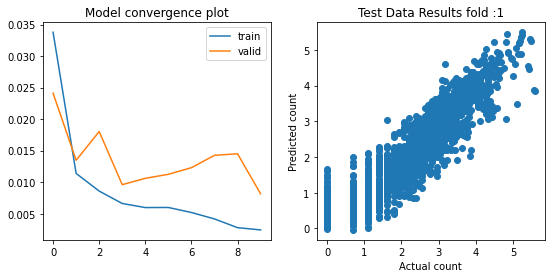

                  train     valid      test
rmse           0.348291  0.503705  0.518235
pearson_corr   0.968110  0.931578  0.920485
spearman_corr  0.973391  0.933215  0.930461
r2             0.930456  0.857148  0.839667
**********************************************************************
**********************************************************************
Train-Valid --> Fold: 1&3 :::: Test--> Fold: 2
epoch:0    train_loss:0.0365    valid_loss:0.0255
epoch:1    train_loss:0.0125    valid_loss:0.0135
epoch:2    train_loss:0.0097    valid_loss:0.009
epoch:3    train_loss:0.0074    valid_loss:0.0092
epoch:4    train_loss:0.0057    valid_loss:0.0202
epoch:5    train_loss:0.0053    valid_loss:0.0087
epoch:6    train_loss:0.0047    valid_loss:0.0145
epoch:7    train_loss:0.0047    valid_loss:0.0084
epoch:8    train_loss:0.0045    valid_loss:0.0109
epoch:9    train_loss:0.0042    valid_loss:0.0141


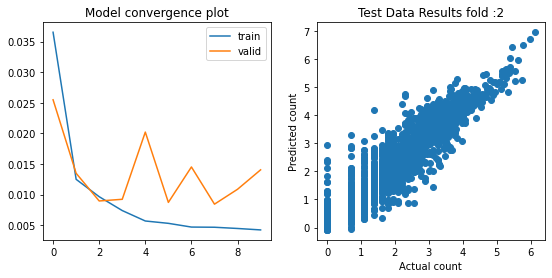

                  train     valid      test
rmse           0.553488  0.659792  0.618362
pearson_corr   0.970092  0.935737  0.921920
spearman_corr  0.972348  0.944662  0.917503
r2             0.833116  0.745371  0.763969
**********************************************************************
**********************************************************************
Train-Valid --> Fold: 1&2 :::: Test--> Fold: 3
epoch:0    train_loss:0.03    valid_loss:0.0157
epoch:1    train_loss:0.0103    valid_loss:0.0156
epoch:2    train_loss:0.008    valid_loss:0.0122
epoch:3    train_loss:0.0063    valid_loss:0.0062
epoch:4    train_loss:0.0049    valid_loss:0.0098
epoch:5    train_loss:0.0043    valid_loss:0.0101
epoch:6    train_loss:0.0048    valid_loss:0.0106
epoch:7    train_loss:0.0041    valid_loss:0.0084
epoch:8    train_loss:0.0039    valid_loss:0.0154
epoch:9    train_loss:0.0036    valid_loss:0.0096


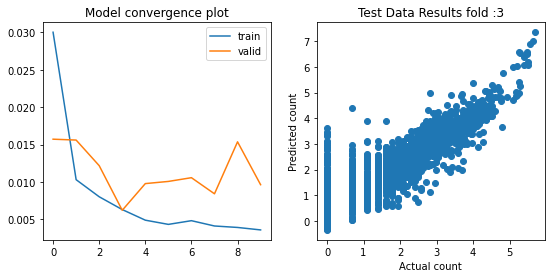

                  train     valid      test
rmse           0.404447  0.542602  0.739075
pearson_corr   0.966093  0.929641  0.875925
spearman_corr  0.969459  0.930108  0.877490
r2             0.901520  0.817978  0.707156
**********************************************************************
**********************************************************************


In [ ]:
#cell_count,images,split = read_data()
unique_splits = [1,2,3]
for test_idx in range(1,4,1):
    num_epochs = 20
    batch_size = 32
    cell_col_idx = 2
    idx_ls = list(set(unique_splits)-set([test_idx]))
    idx_ls.append(test_idx)
    lr = 0.001

    print(f"Train-Valid --> Fold: {idx_ls[0]}&{idx_ls[1]} :::: Test--> Fold: {idx_ls[2]}")

    model = models.resnet18(pretrained=True)
    in_features = model.fc.in_features # updating the last layer to output the required dimension of labels
    model.fc = nn.Linear(in_features,1)

    model = model.to(device)
    loss_fn = nn.MSELoss()
    opt = optim.Adam(model.parameters(), lr=lr)


    train_dataloader,valid_dataloader,test_dataloader,y_train,y_val,y_test = split_level_data(cell_count,images,split,idx_ls,cell_col_idx,batch_size)
    model,loss_ls_train,loss_ls_valid = train_model(loss_fn,model,train_dataloader,valid_dataloader,num_epochs,len(y_train),len(y_val),True)

    
    train_predictions,train_metric = evaluation_metric(train_dataloader,model,y_train.iloc[:,cell_col_idx])
    valid_predictions,valid_metric = evaluation_metric(valid_dataloader,model,y_val.iloc[:,cell_col_idx])
    test_predictions,test_metric = evaluation_metric(test_dataloader,model,y_test.iloc[:,cell_col_idx])

    visualization(loss_ls_train,loss_ls_valid,y_test.iloc[:,cell_col_idx],test_predictions,idx_ls[-1])
    metric_all = {'train':train_metric,'valid':valid_metric,'test':test_metric}
    print(pd.DataFrame(metric_all))
    print("*"*70)
    print("*"*70)

# Consolidated Comparison Table of models on T3 cell count prediction
Siginificant improvement is seen using CNN over classical approach

Note-
1.   feature engg. refers to transformation in target variable, refer to Q-2
2.   Resnet18 are the aggregated values over 3 folds test results




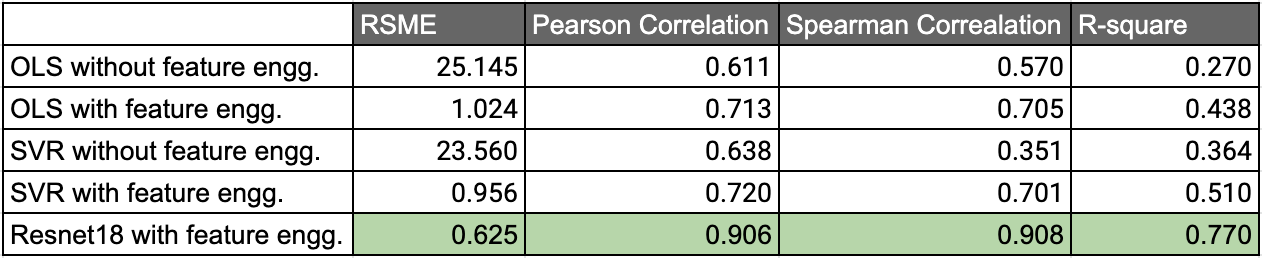

part - (c)

results for each cell types at fold level and aggreagted is level is shown as an output using above written logic and model.

Scroll to the bottom of the output to see the summary results

Findings - In Neutrophil and Eosinophil, around 80% of the records are populated with zeroes, so is the reason that model doesn't show good results on them.

Result for cell type :T1
Train-Valid --> Fold: 2&3 :::: Test--> Fold: 1
epoch:0    train_loss:0.0209    valid_loss:0.0113
epoch:1    train_loss:0.0094    valid_loss:0.0104
epoch:2    train_loss:0.0087    valid_loss:0.0099
epoch:3    train_loss:0.008    valid_loss:0.0113
epoch:4    train_loss:0.0075    valid_loss:0.0089
epoch:5    train_loss:0.0065    valid_loss:0.0129
epoch:6    train_loss:0.0053    valid_loss:0.0188
epoch:7    train_loss:0.0041    valid_loss:0.0179
epoch:8    train_loss:0.0038    valid_loss:0.0315
epoch:9    train_loss:0.003    valid_loss:0.0375


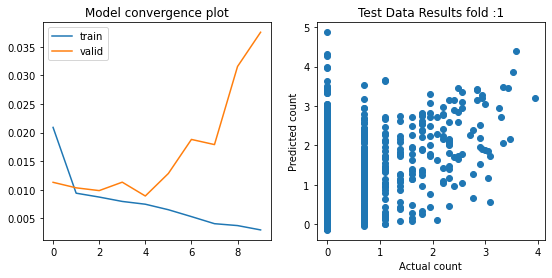

**********************************************************************
Train-Valid --> Fold: 1&3 :::: Test--> Fold: 2
epoch:0    train_loss:0.0173    valid_loss:0.0268
epoch:1    train_loss:0.0091    valid_loss:0.0177
epoch:2    train_loss:0.0088    valid_loss:0.0151
epoch:3    train_loss:0.0079    valid_loss:0.0376
epoch:4    train_loss:0.0072    valid_loss:0.0067
epoch:5    train_loss:0.0055    valid_loss:0.0066
epoch:6    train_loss:0.0061    valid_loss:0.0193
epoch:7    train_loss:0.0051    valid_loss:0.0069
epoch:8    train_loss:0.0041    valid_loss:0.0127
epoch:9    train_loss:0.0033    valid_loss:0.008


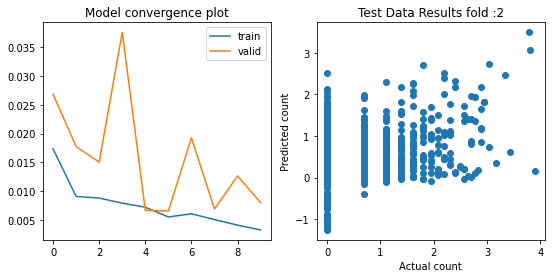

**********************************************************************
Train-Valid --> Fold: 1&2 :::: Test--> Fold: 3
epoch:0    train_loss:0.0236    valid_loss:0.0104
epoch:1    train_loss:0.0121    valid_loss:0.0122
epoch:2    train_loss:0.011    valid_loss:0.0145
epoch:3    train_loss:0.0091    valid_loss:0.0109
epoch:4    train_loss:0.0072    valid_loss:0.0187
epoch:5    train_loss:0.0054    valid_loss:0.0145
epoch:6    train_loss:0.0048    valid_loss:0.0124
epoch:7    train_loss:0.0041    valid_loss:0.0099
epoch:8    train_loss:0.0035    valid_loss:0.0202
epoch:9    train_loss:0.0031    valid_loss:0.0145


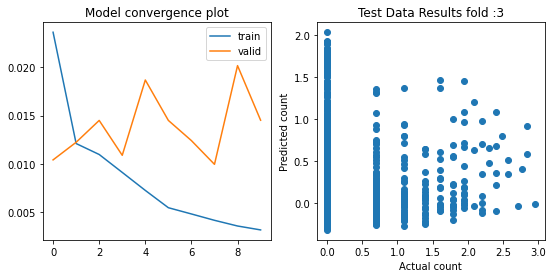

**********************************************************************
######################################################################
Result for cell type :T2
Train-Valid --> Fold: 2&3 :::: Test--> Fold: 1
epoch:0    train_loss:0.0532    valid_loss:0.0166
epoch:1    train_loss:0.0146    valid_loss:0.012
epoch:2    train_loss:0.0082    valid_loss:0.0149
epoch:3    train_loss:0.0065    valid_loss:0.0115
epoch:4    train_loss:0.0068    valid_loss:0.0115
epoch:5    train_loss:0.0077    valid_loss:0.0154
epoch:6    train_loss:0.0054    valid_loss:0.0193
epoch:7    train_loss:0.0051    valid_loss:0.0076
epoch:8    train_loss:0.0043    valid_loss:0.0051
epoch:9    train_loss:0.0041    valid_loss:0.0358


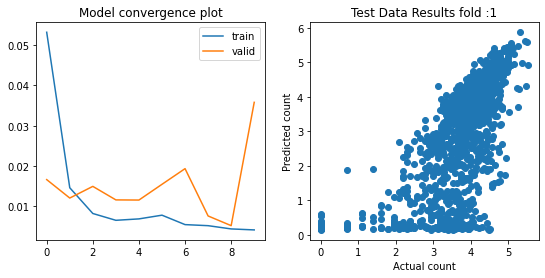

**********************************************************************
Train-Valid --> Fold: 1&3 :::: Test--> Fold: 2
epoch:0    train_loss:0.0532    valid_loss:0.03
epoch:1    train_loss:0.0154    valid_loss:0.027
epoch:2    train_loss:0.0119    valid_loss:0.0144
epoch:3    train_loss:0.0094    valid_loss:0.0141
epoch:4    train_loss:0.0068    valid_loss:0.018
epoch:5    train_loss:0.0056    valid_loss:0.0061
epoch:6    train_loss:0.0034    valid_loss:0.008
epoch:7    train_loss:0.0029    valid_loss:0.0059
epoch:8    train_loss:0.003    valid_loss:0.0063
epoch:9    train_loss:0.0031    valid_loss:0.0048


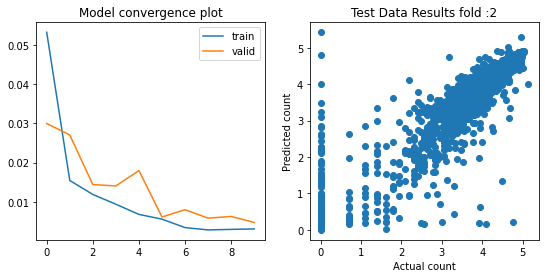

**********************************************************************
Train-Valid --> Fold: 1&2 :::: Test--> Fold: 3
epoch:0    train_loss:0.0526    valid_loss:0.018
epoch:1    train_loss:0.018    valid_loss:0.0293
epoch:2    train_loss:0.0111    valid_loss:0.0316
epoch:3    train_loss:0.0079    valid_loss:0.0088
epoch:4    train_loss:0.0062    valid_loss:0.0126
epoch:5    train_loss:0.0061    valid_loss:0.0121
epoch:6    train_loss:0.0068    valid_loss:0.0107
epoch:7    train_loss:0.0051    valid_loss:0.0078
epoch:8    train_loss:0.0041    valid_loss:0.0181
epoch:9    train_loss:0.0038    valid_loss:0.009


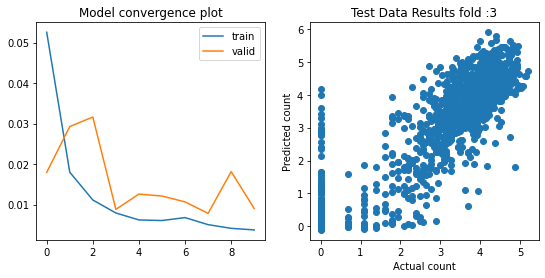

**********************************************************************
######################################################################
Result for cell type :T3
Train-Valid --> Fold: 2&3 :::: Test--> Fold: 1
epoch:0    train_loss:0.036    valid_loss:0.0176
epoch:1    train_loss:0.0116    valid_loss:0.0143
epoch:2    train_loss:0.0081    valid_loss:0.0138
epoch:3    train_loss:0.0059    valid_loss:0.0167
epoch:4    train_loss:0.005    valid_loss:0.0255
epoch:5    train_loss:0.0054    valid_loss:0.0152
epoch:6    train_loss:0.0049    valid_loss:0.0115
epoch:7    train_loss:0.004    valid_loss:0.0092
epoch:8    train_loss:0.0035    valid_loss:0.011
epoch:9    train_loss:0.0027    valid_loss:0.0127


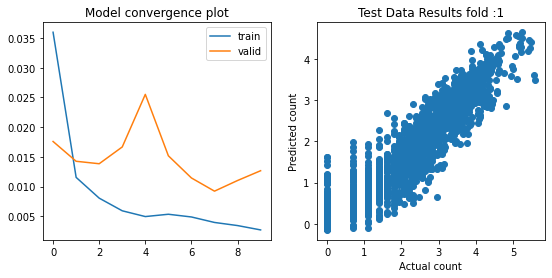

**********************************************************************
Train-Valid --> Fold: 1&3 :::: Test--> Fold: 2
epoch:0    train_loss:0.0433    valid_loss:0.0106
epoch:1    train_loss:0.0121    valid_loss:0.0101
epoch:2    train_loss:0.0089    valid_loss:0.0111
epoch:3    train_loss:0.0072    valid_loss:0.0118
epoch:4    train_loss:0.0062    valid_loss:0.0252
epoch:5    train_loss:0.0057    valid_loss:0.0128
epoch:6    train_loss:0.0046    valid_loss:0.01
epoch:7    train_loss:0.0054    valid_loss:0.01
epoch:8    train_loss:0.004    valid_loss:0.0107
epoch:9    train_loss:0.0034    valid_loss:0.0087


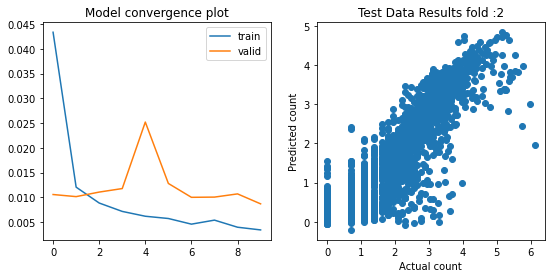

**********************************************************************
Train-Valid --> Fold: 1&2 :::: Test--> Fold: 3
epoch:0    train_loss:0.0385    valid_loss:0.0187
epoch:1    train_loss:0.0106    valid_loss:0.0146
epoch:2    train_loss:0.0078    valid_loss:0.0084
epoch:3    train_loss:0.0063    valid_loss:0.0094
epoch:4    train_loss:0.0057    valid_loss:0.0108
epoch:5    train_loss:0.0087    valid_loss:0.0158
epoch:6    train_loss:0.0062    valid_loss:0.0069
epoch:7    train_loss:0.0045    valid_loss:0.0152
epoch:8    train_loss:0.0041    valid_loss:0.0102
epoch:9    train_loss:0.0041    valid_loss:0.0207


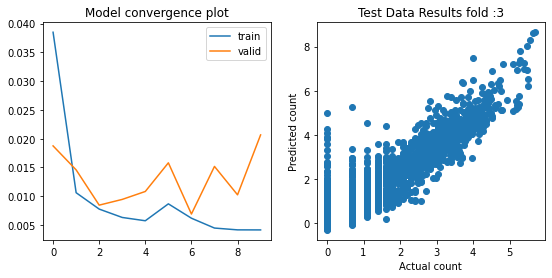

**********************************************************************
######################################################################
Result for cell type :T4
Train-Valid --> Fold: 2&3 :::: Test--> Fold: 1
epoch:0    train_loss:0.0275    valid_loss:0.0249
epoch:1    train_loss:0.0123    valid_loss:0.0299
epoch:2    train_loss:0.0095    valid_loss:0.0185
epoch:3    train_loss:0.007    valid_loss:0.029
epoch:4    train_loss:0.006    valid_loss:0.0203
epoch:5    train_loss:0.006    valid_loss:0.0171
epoch:6    train_loss:0.0055    valid_loss:0.0162
epoch:7    train_loss:0.0045    valid_loss:0.0115
epoch:8    train_loss:0.0035    valid_loss:0.0159
epoch:9    train_loss:0.0029    valid_loss:0.0121


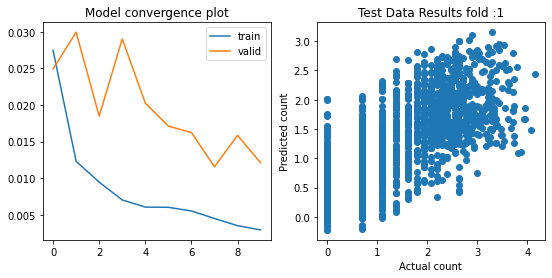

**********************************************************************
Train-Valid --> Fold: 1&3 :::: Test--> Fold: 2
epoch:0    train_loss:0.0326    valid_loss:0.0128
epoch:1    train_loss:0.0122    valid_loss:0.0114
epoch:2    train_loss:0.0086    valid_loss:0.0121
epoch:3    train_loss:0.0062    valid_loss:0.0111
epoch:4    train_loss:0.0056    valid_loss:0.0124
epoch:5    train_loss:0.0051    valid_loss:0.0175
epoch:6    train_loss:0.0049    valid_loss:0.0104
epoch:7    train_loss:0.0039    valid_loss:0.0183
epoch:8    train_loss:0.0036    valid_loss:0.0162
epoch:9    train_loss:0.0034    valid_loss:0.0121


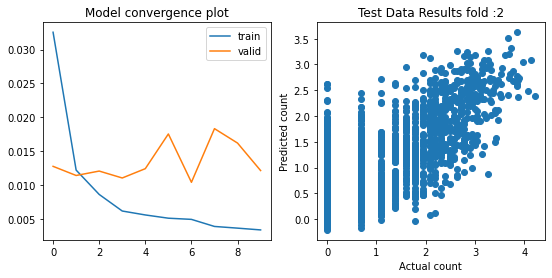

**********************************************************************
Train-Valid --> Fold: 1&2 :::: Test--> Fold: 3
epoch:0    train_loss:0.0367    valid_loss:0.0241
epoch:1    train_loss:0.0127    valid_loss:0.0126
epoch:2    train_loss:0.0099    valid_loss:0.0204
epoch:3    train_loss:0.008    valid_loss:0.0101
epoch:4    train_loss:0.0058    valid_loss:0.0163
epoch:5    train_loss:0.0049    valid_loss:0.0177
epoch:6    train_loss:0.0053    valid_loss:0.0124
epoch:7    train_loss:0.0048    valid_loss:0.0205
epoch:8    train_loss:0.0044    valid_loss:0.0117
epoch:9    train_loss:0.0035    valid_loss:0.0182


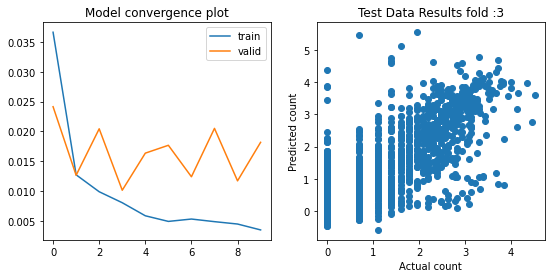

**********************************************************************
######################################################################
Result for cell type :T5
Train-Valid --> Fold: 2&3 :::: Test--> Fold: 1
epoch:0    train_loss:0.0178    valid_loss:0.0083
epoch:1    train_loss:0.0072    valid_loss:0.0095
epoch:2    train_loss:0.0068    valid_loss:0.0082
epoch:3    train_loss:0.0063    valid_loss:0.0051
epoch:4    train_loss:0.0053    valid_loss:0.0092
epoch:5    train_loss:0.0043    valid_loss:0.0075
epoch:6    train_loss:0.0037    valid_loss:0.0111
epoch:7    train_loss:0.0034    valid_loss:0.0076
epoch:8    train_loss:0.0027    valid_loss:0.0051
epoch:9    train_loss:0.0025    valid_loss:0.0081


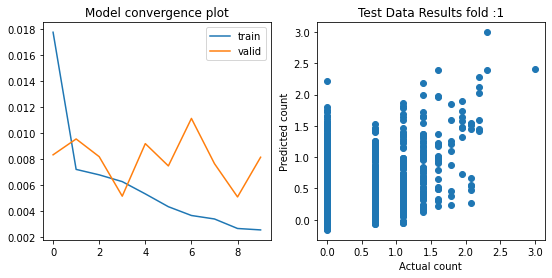

**********************************************************************
Train-Valid --> Fold: 1&3 :::: Test--> Fold: 2
epoch:0    train_loss:0.0143    valid_loss:0.0064
epoch:1    train_loss:0.006    valid_loss:0.0062
epoch:2    train_loss:0.0047    valid_loss:0.0056
epoch:3    train_loss:0.0034    valid_loss:0.0049
epoch:4    train_loss:0.0027    valid_loss:0.0064
epoch:5    train_loss:0.0025    valid_loss:0.0106
epoch:6    train_loss:0.0022    valid_loss:0.0059
epoch:7    train_loss:0.0018    valid_loss:0.0088
epoch:8    train_loss:0.0018    valid_loss:0.0038
epoch:9    train_loss:0.0014    valid_loss:0.004


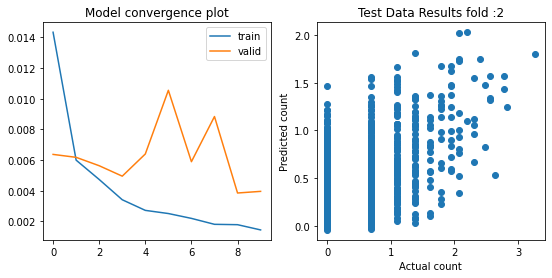

**********************************************************************
Train-Valid --> Fold: 1&2 :::: Test--> Fold: 3
epoch:0    train_loss:0.0134    valid_loss:0.0066
epoch:1    train_loss:0.0061    valid_loss:0.0102
epoch:2    train_loss:0.0051    valid_loss:0.0134
epoch:3    train_loss:0.0044    valid_loss:0.0066
epoch:4    train_loss:0.0031    valid_loss:0.0059
epoch:5    train_loss:0.0026    valid_loss:0.0073
epoch:6    train_loss:0.002    valid_loss:0.0071
epoch:7    train_loss:0.0017    valid_loss:0.0053
epoch:8    train_loss:0.0013    valid_loss:0.0063
epoch:9    train_loss:0.0013    valid_loss:0.0061


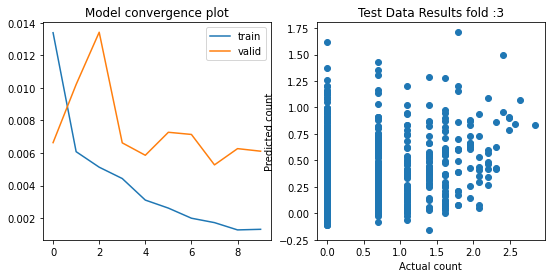

**********************************************************************
######################################################################
Result for cell type :T6
Train-Valid --> Fold: 2&3 :::: Test--> Fold: 1
epoch:0    train_loss:0.0356    valid_loss:0.0353
epoch:1    train_loss:0.014    valid_loss:0.0143
epoch:2    train_loss:0.0109    valid_loss:0.0153
epoch:3    train_loss:0.0077    valid_loss:0.0146
epoch:4    train_loss:0.0061    valid_loss:0.0127
epoch:5    train_loss:0.0054    valid_loss:0.0134
epoch:6    train_loss:0.0048    valid_loss:0.018
epoch:7    train_loss:0.0049    valid_loss:0.0118
epoch:8    train_loss:0.0037    valid_loss:0.0134
epoch:9    train_loss:0.0031    valid_loss:0.0113


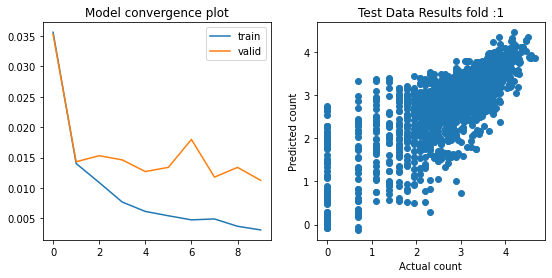

**********************************************************************
Train-Valid --> Fold: 1&3 :::: Test--> Fold: 2
epoch:0    train_loss:0.0397    valid_loss:0.0388
epoch:1    train_loss:0.0185    valid_loss:0.0412
epoch:2    train_loss:0.0139    valid_loss:0.0133
epoch:3    train_loss:0.0106    valid_loss:0.0137
epoch:4    train_loss:0.0092    valid_loss:0.0186
epoch:5    train_loss:0.0077    valid_loss:0.0175
epoch:6    train_loss:0.0059    valid_loss:0.0113
epoch:7    train_loss:0.0053    valid_loss:0.0248
epoch:8    train_loss:0.0046    valid_loss:0.0109
epoch:9    train_loss:0.0041    valid_loss:0.0196


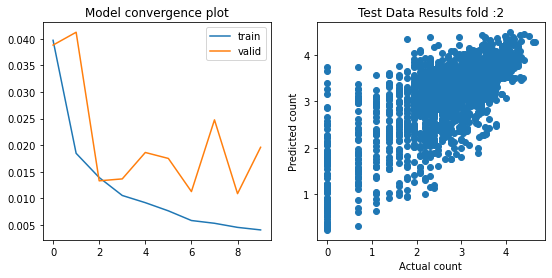

**********************************************************************
Train-Valid --> Fold: 1&2 :::: Test--> Fold: 3
epoch:0    train_loss:0.0341    valid_loss:0.0182
epoch:1    train_loss:0.0163    valid_loss:0.0162
epoch:2    train_loss:0.0123    valid_loss:0.017
epoch:3    train_loss:0.0095    valid_loss:0.0116
epoch:4    train_loss:0.0078    valid_loss:0.0173
epoch:5    train_loss:0.0059    valid_loss:0.0244
epoch:6    train_loss:0.0048    valid_loss:0.0098
epoch:7    train_loss:0.0048    valid_loss:0.0122
epoch:8    train_loss:0.0048    valid_loss:0.0129
epoch:9    train_loss:0.0042    valid_loss:0.0131


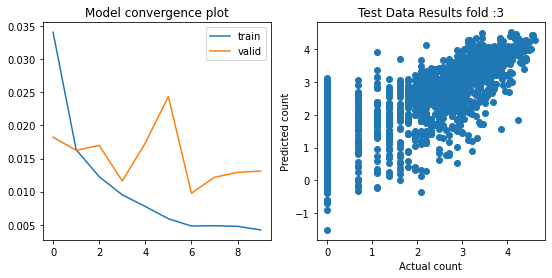

**********************************************************************
######################################################################
Fold Level Results
        rmse  pearson_corr  spearman_corr        r2  fold cell_type
0   1.202757      0.345951       0.277796 -2.487387   1.0       T_0
1   0.645815      0.417979       0.367259  0.016333   2.0       T_0
2   0.628423      0.120461       0.200681 -0.619122   3.0       T_0
3   1.222812      0.785096       0.796272  0.337020   1.0       T_1
4   0.587308      0.913586       0.906644  0.834417   2.0       T_1
5   0.695914      0.917742       0.850580  0.827711   3.0       T_1
6   0.691291      0.915085       0.922131  0.714707   1.0       T_2
7   0.748219      0.866089       0.879518  0.654426   2.0       T_2
8   0.866013      0.896831       0.899701  0.597923   3.0       T_2
9   0.736031      0.775349       0.775482  0.577615   1.0       T_3
10  0.708423      0.751517       0.722741  0.564387   2.0       T_3
11  0.853997      0.734

In [ ]:
results_df = pd.DataFrame()
for i in range(0,6):
    print(f"Result for cell type :T{i+1}")
    unique_splits = [1,2,3]
    for test_idx in range(1,4,1):
        num_epochs = 20
        batch_size = 32
        cell_col_idx = i
        idx_ls = list(set(unique_splits)-set([test_idx]))
        idx_ls.append(test_idx)
        lr = 0.001

        print(f"Train-Valid --> Fold: {idx_ls[0]}&{idx_ls[1]} :::: Test--> Fold: {idx_ls[2]}")

        model = models.resnet18(pretrained=True)
        in_features = model.fc.in_features # updating the last layer to output the required dimension of labels
        model.fc = nn.Linear(in_features,1) 

        model = model.to(device)
        loss_fn = nn.MSELoss()
        opt = optim.Adam(model.parameters(), lr=lr) # Adam optimizer

        train_dataloader,valid_dataloader,test_dataloader,y_train,y_val,y_test = split_level_data(cell_count,images,split,idx_ls,cell_col_idx,batch_size)
        model,loss_ls_train,loss_ls_valid = train_model(loss_fn,model,train_dataloader,valid_dataloader,num_epochs,len(y_train),len(y_val),True)

        train_predictions,train_metric = evaluation_metric(train_dataloader,model,y_train.iloc[:,cell_col_idx])
        valid_predictions,valid_metric = evaluation_metric(valid_dataloader,model,y_val.iloc[:,cell_col_idx])
        test_predictions,test_metric = evaluation_metric(test_dataloader,model,y_test.iloc[:,cell_col_idx])

        visualization(loss_ls_train,loss_ls_valid,y_test.iloc[:,cell_col_idx],test_predictions,idx_ls[-1])
        metric_all = {'train':train_metric,'valid':valid_metric,'test':test_metric}
        metric_df =  pd.DataFrame(metric_all)
        metric_df['cell_type'] = f'T_{i}'
        metric_df['test_fold'] = idx_ls[2]
        results_df = results_df.append(metric_df)
        print("*"*70)
    print("#"*70)

print_df = pd.DataFrame()
for i in range(0,6):
    for fold in range(0,3):
        tmp_df = results_df[(results_df["cell_type"]==f"T_{i}")&(results_df["test_fold"]==fold+1)]["test"].T
        tmp_df['fold'] = int(fold+1)
        tmp_df['cell_type'] = f"T_{i}"
        tmp_df = tmp_df.reset_index(drop=True)
        print_df = print_df.append(tmp_df).reset_index(drop=True)

print_df.columns = ["rmse","pearson_corr","spearman_corr","r2","fold","cell_type"]

print("Fold Level Results")
print(print_df)

print("Aggregated Rasults at cell level")
print(print_df.groupby(["cell_type"]).agg("mean")[['rmse','pearson_corr','spearman_corr','r2']])